## Q1. Web Scraping the wikipedia page to prepapre dataframe of postal codes and neighborhoods

In [1]:
#!conda install -c conda-forge beautifulsoup4 --yes
#!conda install -c conda-forge lxml --yes
#!conda install -c conda-forge folium --yes
#!conda install -c conda-forge geopy --yes

In [2]:
import bs4 as bs
import lxml
import urllib.request
import pandas as pd
import numpy as np

#### Read the url, find table and rows

In [3]:
#open the wiki url and read it
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = bs.BeautifulSoup(source,'lxml')

#find the table isntance in the source
table = soup.find('table')
#find row html tags in the table
table_rows = table.find_all('tr')

In [4]:
Canada = []
#find each td table data/cells in each row and append the text values to canada list 
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text.rstrip() for i in td]
    Canada.append(row)

#### Prepare the dataframe from the extracted table rows and cells

In [5]:
#split the canada list into 3 more lists, 1 each for postalcode, borough and neighborhood. Pass these 3 lists as coloumns to the dataframe
PostalCode = []
Borough = []
Neighborhood = []

for i in range(1,len(Canada)):
    PostalCode.append(Canada[i][0]) 
    Borough.append(Canada[i][1])
    Neighborhood.append(Canada[i][2])

Canada_df = pd.DataFrame()
Canada_df['PostalCode'] = PostalCode
Canada_df['Borough'] = Borough
Canada_df['Neighborhood'] = Neighborhood

print(Canada_df.shape)
Canada_df.head()

(287, 3)


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Drop the rows which has 'Not assigned' Borough value

In [6]:
#set Borough as index, drop those borough which has Not assigned values, reset the index back
Canada_df = Canada_df.set_index('Borough')
Canada_df.drop("Not assigned", axis = 0, inplace = True)
Canada_df = Canada_df.reset_index()
Canada_df = Canada_df[["PostalCode","Borough","Neighborhood"]]
Canada_df.head(7)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Not assigned


#### Where Neighborhood is not assigned, replace it with Borough value

In [7]:
#check how many rows has not assigned neighborhood value. Only 1
Canada_df.index[Canada_df["Neighborhood"] == "Not assigned"].tolist()

[6]

In [8]:
#replace the value
Canada_df.Neighborhood.replace("Not assigned",Canada_df.Borough,inplace=True)
Canada_df.head(7)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Queen's Park


In [9]:
#After replace, check again if any rows has not assigned in neighborhood and print those index. None
Canada_df.index[Canada_df["Neighborhood"] == "Not assigned"].tolist()

[]

#### Grouping rows based on PostalCode and Borough values

In [10]:
Canada_df = Canada_df.groupby(["PostalCode","Borough"])["Neighborhood"].apply(", ".join).reset_index()
Canada_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Final shape of the dataframe

In [11]:
Canada_df.shape

(103, 3)

<h1>Q2 Merge cordinates csv with the dataframe prepared above to get the final dataframe with all required columns</h1>

#### I tried to get cordinates using geocoder code but I got timeout error and it didn't work. So I went ahead and used the csv file provided

In [12]:
#read the csv file provided into a dataframe
geocord_df = pd.read_csv("http://cocl.us/Geospatial_data")
geocord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge both dataframes based on postalcode column

In [13]:
#merge dataframes and drop the redundant postal code column
Canada_df = Canada_df.merge(geocord_df, left_on='PostalCode', right_on='Postal Code')
Canada_df.drop('Postal Code', axis=1, inplace=True)
Canada_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Final size of the dataframe

In [14]:
Canada_df.shape

(103, 5)

<h1>Q3 Explore the Tronto Boroughs using the FourSquare API. Cluster and Segment the neighborhoods</h1>

In [15]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

print('Libraries imported.')

Libraries imported.


In [16]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['source', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h4> For simple visualization and analysis, I'm taking only 1 borough that is Downtown Toronto </h4>

In [17]:
Toronto_data = Canada_df[Canada_df['Borough'] == "Downtown Toronto"].reset_index(drop=True)
Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


##### Get geographical cordinates for Downtown Toronto

In [18]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6541737, -79.38081164513409.


##### Map of Downtown Toronto and it's neighborhoods

In [19]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

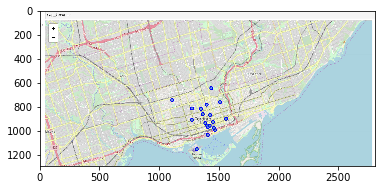

In [20]:
img_t=mpimg.imread('map_Toronto.JPG')
imgplot_t = plt.imshow(img_t)
plt.show()

<h4> To explore and  segment the neighborhoods, I'm using Foursquare API </h4>

In [43]:
#Define foursquare credential and verion

CLIENT_ID = 'I removed my credentials after completing the assignment' # your Foursquare ID
CLIENT_SECRET = 'I removed my credentials after completing the assignment' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I removed my credentials after completing the assignment
CLIENT_SECRET:I removed my credentials after completing the assignment


#### Get the top 100 venues that are in Downtown Toronto Borough neighborhoods within a radius of 500 meters.

In [22]:
#function to extact top 100 venues  in all neighborhoods

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *Toronto_venues*.

In [23]:
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )


Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


In [24]:
#size of the dataframe
print(Toronto_venues.shape)
Toronto_venues.head(20)

(1304, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
5,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner
6,"Cabbagetown, St. James Town",43.667967,-79.367675,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
7,"Cabbagetown, St. James Town",43.667967,-79.367675,Murgatroid,43.667381,-79.369311,Restaurant
8,"Cabbagetown, St. James Town",43.667967,-79.367675,Merryberry Cafe + Bistro,43.666630,-79.368792,Café
9,"Cabbagetown, St. James Town",43.667967,-79.367675,F'Amelia,43.667536,-79.368613,Italian Restaurant


In [25]:
#check how many venues were returned for each neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",44,44,44,44,44,44
Central Bay Street,79,79,79,79,79,79
"Chinatown, Grange Park, Kensington Market",84,84,84,84,84,84
Christie,18,18,18,18,18,18
Church and Wellesley,86,86,86,86,86,86
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


In [26]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 206 uniques categories.


### Analyze Each Neighborhood

In [27]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
Toronto_onehot.shape

(1304, 206)

In [29]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.020000,0.0000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.060000,0.000000,0.000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.01,0.00,0.000000,0.01,0.000000,0.010000,0.000000,0.020000,0.010000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.00,0.01,0.00,0.

In [30]:
Toronto_grouped.shape

(19, 206)

##### Let's print each neighborhood along with the top 5 most common venues

In [31]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.06
1             Café  0.04
2  Thai Restaurant  0.04
3       Steakhouse  0.04
4              Bar  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1  Farmers Market  0.04
2    Cocktail Bar  0.04
3      Steakhouse  0.04
4     Cheese Shop  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.12
1  Airport Terminal  0.12
2       Coffee Shop  0.06
3          Boutique  0.06
4               Bar  0.06


----Cabbagetown, St. James Town----
                venue  freq
0         Coffee Shop  0.07
1                Park  0.05
2                Café  0.05
3         Pizza Place  0.05
4  Italian Restaurant  0.05


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.18
1   Italian Restaurant  0.05
2         Burger Joint  0.04
3  Japanese Restaurant  0.0

In [32]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
#Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Bar,Café,Thai Restaurant,Bakery,Sushi Restaurant,Restaurant,Gastropub,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cheese Shop,Steakhouse,Cocktail Bar,Café,Seafood Restaurant,Farmers Market,Bakery,Beer Bar,Greek Restaurant
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Lounge,Boutique,Rental Car Location,Plane,Boat or Ferry,Harbor / Marina,Coffee Shop,Airport Service,Airport Gate
3,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Pizza Place,Park,Café,Chinese Restaurant,Italian Restaurant,Restaurant,Pub,Jewelry Store
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Juice Bar,Salad Place,Bakery,Bar,Café


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [34]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 3, 0, 4, 0, 2, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,0,Coffee Shop,Bakery,Pizza Place,Park,Café,Chinese Restaurant,Italian Restaurant,Restaurant,Pub,Jewelry Store
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Hotel,Pizza Place,Burger Joint,Men's Store,Mediterranean Restaurant
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,4,Coffee Shop,Pub,Park,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Café,Theater,Farmers Market
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Japanese Restaurant,Café,Cosmetics Shop,Bakery,Electronics Store,Italian Restaurant,Lingerie Store,Middle Eastern Restaurant


#### visualize the resulting clusters

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

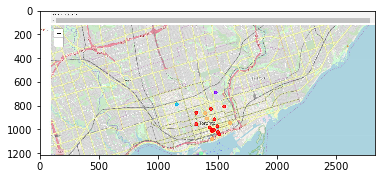

In [37]:
img_c=mpimg.imread('map_clusters.JPG')
imgplot_c = plt.imshow(img_c)
plt.show()

## Examine Clusters

Examine each cluster to see the discriminating venue categories that distinguish each cluster

#### We can see that in cluster 0 first 3 common venues are eateries or related to that

In [38]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,0,Coffee Shop,Bakery,Pizza Place,Park,Café,Chinese Restaurant,Italian Restaurant,Restaurant,Pub,Jewelry Store
2,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Hotel,Pizza Place,Burger Joint,Men's Store,Mediterranean Restaurant
4,Downtown Toronto,0,Clothing Store,Coffee Shop,Japanese Restaurant,Café,Cosmetics Shop,Bakery,Electronics Store,Italian Restaurant,Lingerie Store,Middle Eastern Restaurant
5,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Clothing Store,Cosmetics Shop,Bakery,Breakfast Spot,American Restaurant,Hotel,Italian Restaurant
6,Downtown Toronto,0,Coffee Shop,Cheese Shop,Steakhouse,Cocktail Bar,Café,Seafood Restaurant,Farmers Market,Bakery,Beer Bar,Greek Restaurant
8,Downtown Toronto,0,Coffee Shop,Steakhouse,Bar,Café,Thai Restaurant,Bakery,Sushi Restaurant,Restaurant,Gastropub,Cosmetics Shop
10,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Bakery,Japanese Restaurant,American Restaurant,Steakhouse,Seafood Restaurant
11,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Deli / Bodega,Seafood Restaurant,Italian Restaurant,Steakhouse
12,Downtown Toronto,0,Café,Japanese Restaurant,Bar,Bakery,Restaurant,Bookstore,Yoga Studio,Sandwich Place,Italian Restaurant,Dessert Shop
13,Downtown Toronto,0,Bar,Café,Bakery,Chinese Restaurant,Vietnamese Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Mexican Restaurant,Dumpling Restaurant,Dessert Shop


#### In cluster = 1, common venues are Park, Playground and Trail, which are different compared to other clusters

In [39]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


#### In Cluster = 2, grocery strore, cafe and park which are different

In [40]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,2,Grocery Store,Café,Park,Athletics & Sports,Gas Station,Italian Restaurant,Diner,Nightclub,Candy Store,Restaurant


#### This cluster = 3 is airport zone and all common places are relaetd to that

In [41]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Downtown Toronto,3,Airport Terminal,Airport Lounge,Boutique,Rental Car Location,Plane,Boat or Ferry,Harbor / Marina,Coffee Shop,Airport Service,Airport Gate


#### Cluster 4 looks similar to cluster 0 but this has something different like aquarium, park, gym in the frst 3 common places. Whereas, cluster = 0 has only eateries

In [42]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,4,Coffee Shop,Pub,Park,Bakery,Restaurant,Mexican Restaurant,Breakfast Spot,Café,Theater,Farmers Market
7,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Juice Bar,Salad Place,Bakery,Bar,Café
9,Downtown Toronto,4,Coffee Shop,Aquarium,Café,Italian Restaurant,Hotel,Restaurant,Brewery,Fried Chicken Joint,Scenic Lookout,History Museum
18,Downtown Toronto,4,Coffee Shop,Park,Gym,Burger Joint,College Auditorium,Seafood Restaurant,Sandwich Place,Burrito Place,Portuguese Restaurant,Café
